===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

In [21]:
print __doc__

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

Automatically created module for IPython interactive environment


In [22]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes

2021-01-05 20:38:09,278 Loading LFW people faces from /Users/tobias/scikit_learn_data/lfw_home


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [23]:
def create_pca_data(n_components):
    ###############################################################################
    # Split into a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    ###############################################################################
    # Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
    # dataset): unsupervised feature extraction / dimensionality reduction
    n_components = n_components

    print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
    t0 = time()
    pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
    print "done in %0.3fs" % (time() - t0)

    eigenfaces = pca.components_.reshape((n_components, h, w))

    print "Projecting the input data on the eigenfaces orthonormal basis"
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print "done in %0.3fs" % (time() - t0)
    
    return pca, eigenfaces, X_train_pca, X_test_pca, y_train, y_test

pca, eigenfaces, X_train_pca, X_test_pca, y_train, y_test  = create_pca_data(150)

Extracting the top 150 eigenfaces from 966 faces


/opt/miniconda3/envs/uda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.240s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.043s


In [24]:
###############################################################################
# Train a SVM classification model
def train_svm_model(X_train_pca, y_train):
    print "Fitting the classifier to the training set"
    t0 = time()
    param_grid = {
             'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              }
    # for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(X_train_pca, y_train)
    print "done in %0.3fs" % (time() - t0)
    print "Best estimator found by grid search:"
    print clf.best_estimator_
    
    return clf
    
clf = train_svm_model(X_train_pca, y_train)

Fitting the classifier to the training set
done in 21.562s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [25]:
def get_evaluation_matrix(clf, y_test):
    ###############################################################################
    # Quantitative evaluation of the model quality on the test set

    print "Predicting the people names on the testing set"
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print "done in %0.3fs" % (time() - t0)

    print classification_report(y_test, y_pred, target_names=target_names)
    print confusion_matrix(y_test, y_pred, labels=range(n_classes))
    
get_evaluation_matrix(clf, y_test)

Predicting the people names on the testing set
done in 0.064s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.77      0.65        13
     Colin Powell       0.85      0.78      0.82        60
  Donald Rumsfeld       0.76      0.81      0.79        27
    George W Bush       0.86      0.92      0.89       146
Gerhard Schroeder       0.87      0.80      0.83        25
      Hugo Chavez       1.00      0.73      0.85        15
       Tony Blair       0.93      0.75      0.83        36

      avg / total       0.85      0.84      0.85       322

[[ 10   2   0   1   0   0   0]
 [  1  47   2  10   0   0   0]
 [  2   0  22   3   0   0   0]
 [  4   3   4 135   0   0   0]
 [  0   2   0   2  20   0   1]
 [  1   0   0   2   0  11   1]
 [  0   1   1   4   3   0  27]]


In [26]:
###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

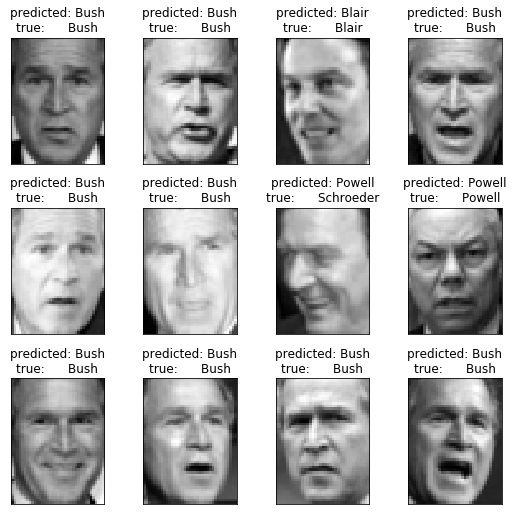

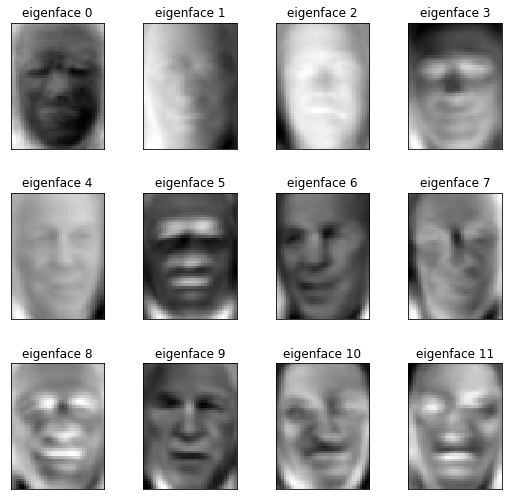

In [27]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

In [28]:
print pca.explained_variance_ratio_
print pca.components_[0]
print pca.components_[1]

[ 0.17834059  0.15017419  0.07357165  0.0610257   0.05375216  0.0303553
  0.02559071  0.02036322  0.02005552  0.01952421  0.01664159  0.0152563
  0.01258194  0.01113433  0.01080861  0.01038579  0.00960764  0.00902738
  0.0086626   0.0074464   0.00681802  0.00666373  0.00630902  0.00617943
  0.00573942  0.0054754   0.00528215  0.00474489  0.00456853  0.00437181
  0.00402143  0.00390822  0.00370732  0.00358776  0.00344204  0.00328453
  0.00309944  0.0030764   0.00306394  0.00297297  0.00284403  0.00282763
  0.00265052  0.00253009  0.00246206  0.00239734  0.00235021  0.00228503
  0.00221238  0.00218296  0.00212444  0.00208873  0.00206929  0.00203265
  0.00198146  0.00193186  0.00184849  0.00179727  0.00177592  0.00174214
  0.00168643  0.0016464   0.00159083  0.00155778  0.00154866  0.00151462
  0.00147846  0.0014615   0.00144714  0.00141866  0.00136715  0.00135442
  0.00130894  0.00128531  0.00127445  0.00125637  0.00122172  0.00120673
  0.00119969  0.00116988  0.00116262  0.0011314   0.0

In [29]:
n_components = [10, 15, 25, 50, 100, 250]
for component in n_components:
    pca, eigenfaces, X_train_pca, X_test_pca, y_train, y_test  = create_pca_data(component)
    clf = train_svm_model(X_train_pca, y_train)
    get_evaluation_matrix(clf, y_test)

Extracting the top 10 eigenfaces from 966 faces
done in 0.106s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.019s
Fitting the classifier to the training set


/opt/miniconda3/envs/uda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 42.983s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.015s
                   precision    recall  f1-score   support

     Ariel Sharon       0.12      0.15      0.14        13
     Colin Powell       0.38      0.43      0.41        60
  Donald Rumsfeld       0.23      0.22      0.23        27
    George W Bush       0.59      0.58      0.58       146
Gerhard Schroeder       0.08      0.08      0.08        25
      Hugo Chavez       0.22      0.27      0.24        15
       Tony Blair       0.36      0.25      0.30        36

      avg / total       0.42      0.41      0.41       322

[[ 2  7  0  4  0  0  0]
 [ 3 26  5 21  3  2  0]
 [ 3  7  6  5  1  1  4]
 [ 6 16 11 84 14  5 10]
 [ 0  4  2 11  2  4  2]
 

/opt/miniconda3/envs/uda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 13.967s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.011s
                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.38      0.33        13
     Colin Powell       0.61      0.65      0.63        60
  Donald Rumsfeld       0.53      0.33      0.41        27
    George W Bush       0.72      0.77      0.75       146
Gerhard Schroeder       0.35      0.32      0.33        25
      Hugo Chavez       0.57      0.53      0.55        15
       Tony Blair       0.50      0.42      0.45        36

      avg / total       0.61      0.61      0.61       322

[[  5   5   0   2   1   0   0]
 [  8  39   2  10   1   0   0]
 [  3   1   9  10   1   0   3]
 [  1  15   3 113   6   4   

/opt/miniconda3/envs/uda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 7.463s
Best estimator found by grid search:
SVC(C=5000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.011s
                   precision    recall  f1-score   support

     Ariel Sharon       0.45      0.77      0.57        13
     Colin Powell       0.75      0.73      0.74        60
  Donald Rumsfeld       0.64      0.78      0.70        27
    George W Bush       0.87      0.84      0.86       146
Gerhard Schroeder       0.50      0.40      0.44        25
      Hugo Chavez       0.73      0.73      0.73        15
       Tony Blair       0.62      0.56      0.59        36

      avg / total       0.75      0.74      0.74       322

[[ 10   3   0   0   0   0   0]
 [  5  44   0  10   0   0   1]
 [  3   0  21   1   0   0   2]
 [  3   6  11 123   2   0  

/opt/miniconda3/envs/uda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 7.404s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.021s
                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.77      0.62        13
     Colin Powell       0.90      0.78      0.84        60
  Donald Rumsfeld       0.71      0.81      0.76        27
    George W Bush       0.89      0.92      0.91       146
Gerhard Schroeder       0.61      0.56      0.58        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.82      0.75      0.78        36

      avg / total       0.83      0.82      0.82       322

[[ 10   2   0   1   0   0   0]
 [  4  47   2   7   0   0   0]
 [  4   0  22   1   0   0   0]
 [  0   1   6 135   3   1   

/opt/miniconda3/envs/uda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.034s
Fitting the classifier to the training set
done in 14.740s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.048s
                   precision    recall  f1-score   support

     Ariel Sharon       0.71      0.77      0.74        13
     Colin Powell       0.91      0.88      0.90        60
  Donald Rumsfeld       0.82      0.85      0.84        27
    George W Bush       0.90      0.96      0.93       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       0.85      0.73      0.79        15
       Tony Blair       0.91      0.83      0.87        36

      avg / total       0.89      0.89      0.89       322

[[ 10   2   0   1   0   0   0]
 [  1  53   1   5   0   0   0]

/opt/miniconda3/envs/uda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.299s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.053s
Fitting the classifier to the training set
done in 44.419s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.110s
                   precision    recall  f1-score   support

     Ariel Sharon       0.71      0.77      0.74        13
     Colin Powell       0.85      0.83      0.84        60
  Donald Rumsfeld       0.88      0.78      0.82        27
    George W Bush       0.86      0.95      0.90       146
Gerhard Schroeder       0.78      0.72      0.75        25
      Hugo Chavez       1.00      0.60      0.75        15
       Tony Blair       0.85      0.78      0.81        36

      avg / total       0.85      0.85      